# Taxonomy of all collected data (BacDive + PCC + PubMed + Bergey's Manual)

In [1]:
import lzma

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from scipy.stats.mstats import gmean

In [41]:
mu = chr(956)
mu

'μ'

### Reference taxonomy

Read NCBI taxonomy database."

In [4]:
dump = {}
with lzma.open('../preprocess/nodes.dmp.xz', 'rb') as f:
    for line in f.read().decode().splitlines():
        x = line.rstrip('\r\n').replace('\t|', '').split('\t')
        dump[x[0]] = {'parent': x[1], 'rank': x[2], 'name': '', 'children': set()}
with lzma.open('../preprocess/names.dmp.xz', 'rb') as f:
    for line in f.read().decode().splitlines():
        x = line.rstrip('\r\n').replace('\t|', '').split('\t')
        if x[3] == 'scientific name':
            dump[x[0]]['name'] = x[1]
for tid in dump:
    pid = dump[tid]['parent']
    if tid != pid:
        dump[pid]['children'].add(tid)

### Data tables

BacDive data

In [5]:
df1 = pd.read_table('../preprocess/annot/species.tsv', sep = '\t', dtype = {'taxid': str})
df1.set_index('taxid', inplace = True)
df1.shape

(4875, 12)

In [6]:
df1['source'] = 'bacdive'

PCC - cyanobacteria

In [7]:
df2 = pd.read_table('../preprocess/annot/species_cyanobacteria.tsv', sep = '\t', dtype = {'taxid': str})
df2.set_index('taxid', inplace = True)
df2.shape

(98, 12)

In [8]:
df2['source'] = 'pcc'

Largest/smalles and common species (PubMed) data

In [9]:
df3 = pd.read_table('../preprocess/annot/species_common_extremes.tsv', sep = '\t', dtype = {'taxid': str})
df3.set_index('taxid', inplace = True)
df3.shape

(53, 12)

In [10]:
df3['source'] = 'pubmed'

Bergey's manual volume 4 - Multiple phyla

In [11]:
df4 = pd.read_table('../preprocess/annot/BM_vol4.tsv', sep = '\t', dtype = {'taxid': str})
df4.set_index('taxid', inplace = True)
df4.shape

(333, 12)

In [12]:
df4['source'] = 'bergeys_vol4'

Bergey's manual volume 5 - Actinobacteria

In [13]:
df5 = pd.read_table('../preprocess/annot/BM_vol5_actinobacteria.tsv', sep = '\t', dtype = {'taxid': str})
df5.set_index('taxid', inplace = True)
df5.shape

(289, 12)

In [14]:
df5['source'] = 'bergeys_vol5'

Bergey's manual volume 1 - Archaea

In [15]:
df6 = pd.read_table('../preprocess/annot/BM_vol1.tsv', sep = '\t', dtype = {'taxid': str})
df6.set_index('taxid', inplace = True)
df6.shape

(94, 12)

In [16]:
df6['source'] = 'bergeys_vol1'

### Concat data

In [45]:
df = pd.concat((df1, df2, df3, df4, df5, df6), axis = 0)

In [46]:
df.shape

(5742, 13)

Check for duplicated data

**Why this data was not detected during pre-processing?**

Because during the preprocessing step I only checkd for names. After asigning a species name according to NCBI taxonomy, the name may have changed. Therefore two names that were different before taxonomic assignment are now the same and therefore share the same taxID.

In [47]:
df.index[df.index.duplicated()].shape

(40,)

Group organisms by taxID and calculate geometric mean per species

In [48]:
cols = ['length', 'width', 'volume', 'surface']

In [49]:
dfr = df.groupby('taxid')[cols].agg(gmean)

Add shape and species name

In [50]:
tmp = df[['shape']].reset_index()

Keep last shape, i.e. according to Bergey's Manual

In [51]:
shapes = dict(tmp.drop_duplicates('taxid', keep = 'last').values)

In [52]:
dfr['shape'] = dfr.index.map(shapes)

Do the same for source

In [53]:
tmp = df[['source']].reset_index()

In [54]:
sources = dict(tmp.drop_duplicates('taxid', keep = 'last').values)

In [55]:
dfr['source'] = dfr.index.map(sources)

In [56]:
dfr['sourcev2'] = dfr['source'].map(lambda x: x if 'bergeys' not in x else 'bergeys')

Add species name

In [57]:
dfr['species'] = dfr.index.to_series().apply(lambda x: dump[str(x)]['name'])

Organize

In [58]:
dfr = dfr.loc[sorted(dfr.index, key=int)]

In [59]:
ranks = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']

In [60]:
res = {x: {} for x in ranks[1:]}
rankset = set(ranks[1:])

In [61]:
for tid in dfr.index.astype(str):
    this = tid
    while True:
        rank = dump[this]['rank']
        if rank in rankset:
            res[rank][tid] = dump[this]['name']
        parent = dump[this]['parent']
        if this == parent:
            break
        this = parent

In [62]:
for rank in ranks[1:]:
    dfr[rank] = dfr.index.map(res[rank])

In [63]:
# Correct entries with no species
dfr['species'] = dfr['species'].astype(str).apply(lambda x: x if len(x.split(' ')) > 1 else np.NaN)

In [64]:
dfr.shape

(5702, 14)

Plots

In [70]:
colors = {'bacdive': '#264653', 'pcc': '#2a9d8f', 'pubmed': '#e9c46a', 'bergeys': '#f4a261'}

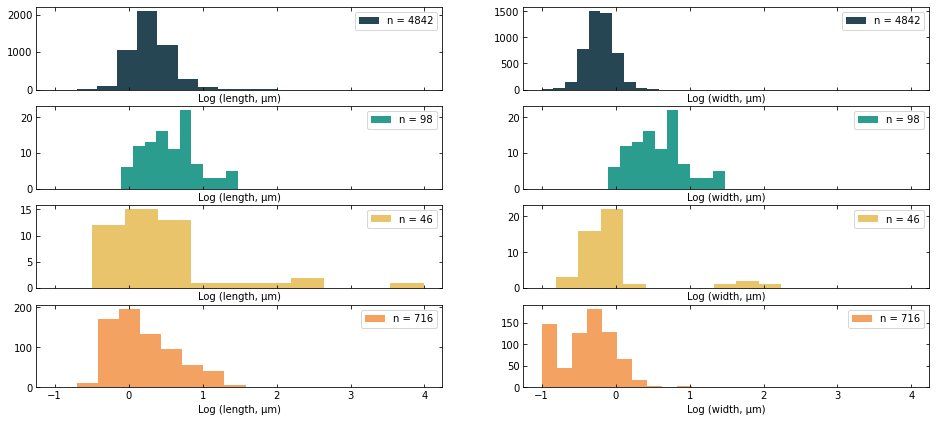

In [90]:
fig, ax = plt.subplots(4, 2, figsize = (16, 7), 
                       sharey = False, sharex = True)

for i, source in enumerate(['bacdive', 'pcc', 'pubmed', 'bergeys']):
    for j, metric in enumerate(['length', 'width']):
        datum = dfr[dfr['sourcev2'] == source][metric].apply(np.log10)
        ax[i, j].hist(datum, color = colors[source],
                     density = False, label = f'n = {len(datum)}')
        ax[i, j].set_xlabel(f'Log ({metric}, {mu}m)')
        ax[i, j].legend()
        ax[i, j].tick_params(top = True, right = True, direction = 'in', which = 'both')

Save data frame

In [93]:
dfr['sourcev2'].to_csv('source.tsv', sep = '\t')

In [89]:
# fig, ax = plt.subplots(1, 4, figsize = (16, 3), 
#                        sharey = False, sharex = True)

# # for i, source in enumerate(['bacdive', 'pcc', 'pubmed', 'bergeys']):
# for j, metric in enumerate(['length', 'width', 'volume', 'surface']):
#     for i, source in enumerate(['bacdive', 'pcc', 'pubmed', 'bergeys']):
#         datum = dfr[dfr['sourcev2'] == source][metric].apply(np.log10)
#         ax[j].hist(datum, color = colors[source],
#                      density = True, label = f'n = {len(datum)}',
#                   alpha = 0.6)
#     ax[j].set_xlabel(f'Log ({metric}, {mu}m)')
#     ax[j].legend()
#     ax[j].tick_params(top = True, right = True, direction = 'in', which = 'both')